In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import os
import gc
from IPython.core.display import display, HTML, display_pretty
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import lightgbm as lgb
from imblearn.datasets import make_imbalance
os.chdir('/home/sambeet/data/dsg/')

Reading data and converting to categorical

In [2]:
trade = pd.read_csv('Trade.csv',parse_dates=['TradeDateKey'])
trade['BuySell'] = trade['BuySell'].astype('category')
trade['TradeStatus'] = trade['TradeStatus'].astype('category')
trade['CustomerInterest'] = trade['CustomerInterest'].astype('bool')

Reading supplement data and convert to categorical

In [3]:
#marketdata = pd.read_csv('Market.csv',parse_dates=['DateKey'])
#macromarketdata = pd.read_csv('MarketData_Macro.csv',parse_dates=['DateKey'])
customer = pd.read_csv('Customer.csv')
categorical_columns = ['Sector','Subsector','Region','Country']
for col in categorical_columns:
    customer[col] = customer[col].astype('category')
bond = pd.read_csv('Isin.csv',parse_dates=['ActualMaturityDateKey', 'IssueDateKey'])
categorical_columns = ['Seniority','Currency','ActivityGroup','Region','Activity',
       'RiskCaptain','Owner','CompositeRating','IndustrySector','IndustrySubgroup','MarketIssue','CouponType']
for col in categorical_columns:
    bond[col] = bond[col].astype('category')

In [4]:
trade['year'] = trade.TradeDateKey.dt.year
trade['month'] = trade.TradeDateKey.dt.month
trade['day'] = trade.TradeDateKey.dt.day
trade['weekday'] = trade.TradeDateKey.dt.dayofweek
trade['weekofyear'] = trade.TradeDateKey.dt.weekofyear
trade['quarter'] = trade.TradeDateKey.dt.quarter

Joining trade data with bond data, bond market data, customer data (Leaving macromarket data for now)

marketdata = marketdata.rename({'DateKey':'TradeDateKey','Price':'BondPrice'},axis=1)
marketdata.head()
trade = trade.merge(marketdata,on=['IsinIdx','TradeDateKey'],how='left')

In [5]:
customer = customer.rename({'Region':'CustomerRegion'},axis=1)
trade = trade.merge(customer,on=['CustomerIdx'],how='left')

In [6]:
bond = bond.rename({'Region':'BondRegion'},axis=1)
trade = trade.merge(bond,on=['IsinIdx'],how='left')

In [7]:
del customer, bond
gc.collect()

53

Create Variables for Time since Issued and Time till Maturity

In [8]:
trade['days_issued'] = (trade['TradeDateKey'] - trade['IssueDateKey']).dt.days

In [9]:
trade['days_maturity'] = (trade['ActualMaturityDateKey'] - trade['TradeDateKey']).dt.days

In [1]:
predictors = list(trade.columns)
predictors.remove('TradeDateKey')
predictors.remove('IsinIdx')
predictors.remove('Price')
predictors.remove('CustomerInterest')
predictors.remove('ActualMaturityDateKey')
predictors.remove('IssueDateKey')
predictors.remove('TradeStatus')
predictors.remove('NotionalEUR')
#predictors.remove('BondPrice')
#predictors.remove('Yield')
#predictors.remove('ZSpread')
predictors.remove('day')
predictors.remove('weekday')
#predictors.remove('weekofyear')

target = 'CustomerInterest'
print(predictors,len(predictors),trade.shape[0])

NameError: name 'trade' is not defined

In [11]:
test = pd.read_csv('Challenge_20180423.csv',parse_dates=['DateKey'])
test = test.rename({'DateKey':'TradeDateKey'},axis=1)
test['BuySell'] = test['BuySell'].astype('category')
test['TradeDateKey'] = '20180423'
test['TradeDateKey'] = pd.to_datetime(test.TradeDateKey)

In [12]:
#marketdata = pd.read_csv('Market.csv',parse_dates=['DateKey'])
#macromarketdata = pd.read_csv('MarketData_Macro.csv',parse_dates=['DateKey'])
customer = pd.read_csv('Customer.csv')
categorical_columns = ['Sector','Subsector','Region','Country']
for col in categorical_columns:
    customer[col] = customer[col].astype('category')
bond = pd.read_csv('Isin.csv',parse_dates=['ActualMaturityDateKey', 'IssueDateKey'])
categorical_columns = ['Seniority','Currency','ActivityGroup','Region','Activity',
       'RiskCaptain','Owner','CompositeRating','IndustrySector','IndustrySubgroup','MarketIssue','CouponType']
for col in categorical_columns:
    bond[col] = bond[col].astype('category')

In [13]:
test['year'] = test.TradeDateKey.dt.year
test['month'] = test.TradeDateKey.dt.month
test['day'] = test.TradeDateKey.dt.day
test['weekday'] = test.TradeDateKey.dt.dayofweek
test['weekofyear'] = test.TradeDateKey.dt.weekofyear
test['quarter'] = test.TradeDateKey.dt.quarter

marketdata = marketdata.rename({'DateKey':'TradeDateKey','Price':'BondPrice'},axis=1)
marketdata.head()
test = test.merge(marketdata,on=['IsinIdx','TradeDateKey'],how='left')

In [14]:
customer = customer.rename({'Region':'CustomerRegion'},axis=1)
test = test.merge(customer,on=['CustomerIdx'],how='left')

In [15]:
bond = bond.rename({'Region':'BondRegion'},axis=1)
test = test.merge(bond,on=['IsinIdx'],how='left')

In [16]:
del customer, bond
gc.collect()

49

In [17]:
test['days_issued'] = (test['TradeDateKey'] - test['IssueDateKey']).dt.days
test['days_maturity'] = (test['ActualMaturityDateKey'] - test['TradeDateKey']).dt.days

In [18]:
categorical_to_be_transformed = ['BuySell','Sector','Subsector','CustomerRegion', 'Country','Seniority','Currency',
                                 'ActivityGroup', 'BondRegion', 'Activity', 'RiskCaptain', 'Owner', 
                                 'CompositeRating', 'IndustrySector', 'IndustrySubgroup', 'MarketIssue','CouponType']
for feature in categorical_to_be_transformed:
    print 'Transforming {}...'.format(feature)
    encoder = LabelEncoder()
    encoder.fit(trade[feature].append(test[feature]).astype(str))    
    trade[feature] = encoder.transform(trade[feature].astype(str))
    test[feature] = encoder.transform(test[feature].astype(str))

Transforming BuySell...
Transforming Sector...
Transforming Subsector...
Transforming CustomerRegion...
Transforming Country...
Transforming Seniority...
Transforming Currency...
Transforming ActivityGroup...
Transforming BondRegion...
Transforming Activity...
Transforming RiskCaptain...
Transforming Owner...
Transforming CompositeRating...
Transforming IndustrySector...
Transforming IndustrySubgroup...
Transforming MarketIssue...
Transforming CouponType...


In [19]:
categorical = categorical_to_be_transformed + ['CustomerIdx','TickerIdx','month','quarter','weekofyear']
print(categorical)

['BuySell', 'Sector', 'Subsector', 'CustomerRegion', 'Country', 'Seniority', 'Currency', 'ActivityGroup', 'BondRegion', 'Activity', 'RiskCaptain', 'Owner', 'CompositeRating', 'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'CouponType', 'CustomerIdx', 'TickerIdx', 'month', 'quarter', 'weekofyear']


In [20]:
trade_undersampled,customerinterest_undersampled = make_imbalance(trade.loc[:,predictors].values,
                                                                  trade[target].values,
                                                                  ratio={0:np.sum(trade.CustomerInterest == 0),
                                                                         1:np.round(0.02*np.sum(trade.CustomerInterest == 0)).astype(int)},
                                                                  random_state=37)

In [21]:
trade_undersampled.shape

(4641094, 26)

In [22]:
#train_index = 4176985
#valid_index = range(4176985,trade_undersampled.shape[0])
train_index, valid_index = train_test_split(np.arange(trade_undersampled.shape[0]), test_size=0.1, random_state=37)

trade.sort_values(by='TradeDateKey',axis=0,inplace=True)
trade.reset_index(drop=True,inplace=True)

In [111]:
rounds = 500
early_stop_rounds = 50

lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric' : 'auc',
    'num_leaves' : 3,
#     'max_depth': 15,
    'learning_rate' : 0.01,
    'feature_fraction' : 0.5,
#    'bagging_fraction' : 0.6,
#    'bagging_freq' : 5,
    'verbosity' : -1,
    'num_threads' : 8,
    'min_data_in_leaf' : 10000,
    'lambda_l1' : 1,
    'lambda_l2' : 1,
#    'cat_smooth' : 50,
    'max_bin' : 50,
#    'is_unbalance' : True,    
    'scale_pos_weight' : 20,    
}

In [112]:
# LGBM Dataset Formatting 
train = lgb.Dataset(trade_undersampled[train_index], customerinterest_undersampled[train_index],
                    feature_name=predictors,categorical_feature = categorical)
valid = lgb.Dataset(trade_undersampled[valid_index], customerinterest_undersampled[valid_index],
                    feature_name=predictors,categorical_feature = categorical)

In [113]:
submit = pd.read_csv('submission_sambeet_4.csv')

In [114]:
model = lgb.train(lgbm_params,train,num_boost_round=rounds,valid_sets=[valid],valid_names=['valid'],
                    early_stopping_rounds=early_stop_rounds,verbose_eval=50)
#del x_valid ; x_train; gc.collect()

Training until validation scores don't improve for 50 rounds.
[50]	valid's auc: 0.915829
[100]	valid's auc: 0.930024
[150]	valid's auc: 0.934899
[200]	valid's auc: 0.936637
[250]	valid's auc: 0.936877
[300]	valid's auc: 0.939959
[350]	valid's auc: 0.947092
[400]	valid's auc: 0.952139
[450]	valid's auc: 0.954243
[500]	valid's auc: 0.956299
Did not meet early stopping. Best iteration is:
[500]	valid's auc: 0.956299


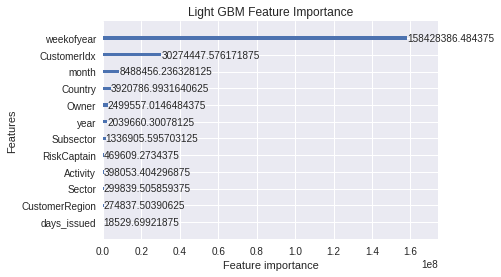

In [105]:
lgb.plot_importance(model,importance_type='gain')
plt.title("Light GBM Feature Importance")

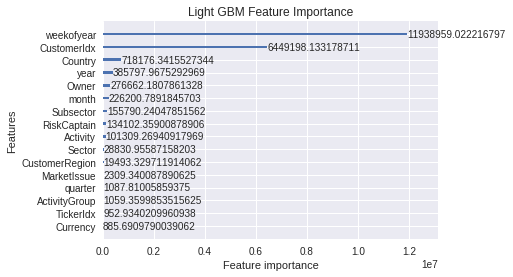

In [115]:
lgb.plot_importance(model,importance_type='gain')
plt.title("Light GBM Feature Importance")

In [106]:
test['CustomerInterest'] = model.predict(test.loc[:,predictors].values)
#test[['PredictionIdx','CustomerInterest']].to_csv('submission_sambeet_6.csv', index=False)

In [107]:
pd.concat([test[target],submit[target]],axis=1).corr()

,CustomerInterest,CustomerInterest
CustomerInterest,1.000000,0.994602
CustomerInterest,0.994602,1.000000


Check overlap between train and test

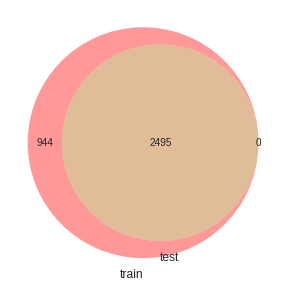

In [260]:
from matplotlib_venn import venn2
 
# Second way
venn2([set(list(trade.CustomerIdx)), set(list(test.CustomerIdx))],set_labels=['train','test'])
plt.show()

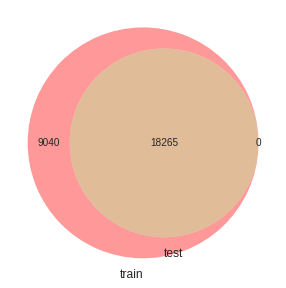

In [261]:
from matplotlib_venn import venn2
 
# Second way
venn2([set(list(trade.IsinIdx)), set(list(test.IsinIdx))],set_labels=['train','test'])
plt.show()

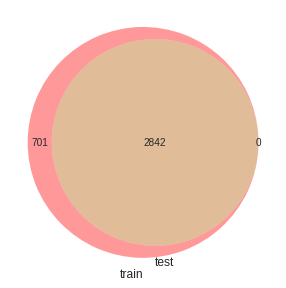

In [262]:
from matplotlib_venn import venn2
 
# Second way
venn2([set(list(trade.TickerIdx)), set(list(test.TickerIdx))],set_labels=['train','test'])
plt.show()

In [264]:
len(np.unique(test.TickerIdx))

2842